# Dollar Cost Averaging


Dollar Cost Averaging (DCA) is an investment strategy that involves regularly investing a fixed amount of money, regardless of market conditions. By consistently purchasing assets over time, DCA aims to reduce the impact of market volatility on the average cost of investments. Consistent investments potentially lead to lower average cost per share over the long term. While DCA promotes disciplined investing and may mitigate the risks associated with market timing, it does not guarantee profits.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as md
import yfinance as yf

## Downloading Data

In [2]:
port = yf.download('SPY')['Adj Close'].reset_index()
port['Date'] = port['Date'].dt.strftime('%Y-%m-%d')
all_dates = pd.DataFrame(pd.date_range(port['Date'].min(), port['Date'].max(), freq = 'd').strftime('%Y-%m-%d').tolist()).rename(columns = {0 : 'Date'})
# create all dates including weekends
port = pd.merge(all_dates, port, how = 'left', left_on = 'Date', right_on = 'Date')
port.ffill(inplace = True)
port['Date'] = pd.to_datetime(port['Date'])

[*********************100%***********************]  1 of 1 completed


## Relevant Functions

In [3]:
def DCA(
        NAV: pd.DataFrame,
        periods: list,
        initial_lump_sum: int, 
        dca_amount: int
) -> dict:
    '''
    Creating DCA dictionary
    '''
    dca_port = {}
    n = 0
    # for each deposit date in investment period, 
    for deposit in periods:
        deposit_nav_df = NAV[NAV['Date'] >= deposit].copy()
        deposit_nav = deposit_nav_df['Adj Close'].iloc[0] # filter nav on invest date
        deposit_nav_df['ret'] = deposit_nav_df['Adj Close'] / deposit_nav # calculate returns since then

        # for initial lump sum deposit, followed by subsequent DCA
        if n == 0:
            dca_port[deposit] = deposit_nav_df['ret'].values * initial_lump_sum   
        else:
            dca_port[deposit] = deposit_nav_df['ret'].values * dca_amount   
        n+=1
  
    return dca_port

def compute_investment(
        dca_port: dict,
        initial_lump_sum: int,
        dca_amount: int
) -> tuple[np.array, np.array]:
    '''
    calculates total principal invested and
    portfolio value
    '''
    investment = {}
    n = 0

    # for initial lump sum deposit, followed by subsequent DCA
    for key, value in dca_port.items():
        investment[key] = [initial_lump_sum] * len(value) if n == 0 else [dca_amount] * len(value)
        n+=1
    
    # first date is first key of dictionary
    first_invest_date = next(iter(dca_port))
    length = dca_port[first_invest_date].shape[0] # total investment days
    
    # placeholders
    total_ret = np.zeros(length)
    principal = np.zeros(length)
    
    # make all values same length by padding 0s to front
    for key, value in dca_port.items():
        length_item = dca_port[key].shape[0]
        append_front = np.zeros(length - length_item)
        dca_port[key] = np.concatenate((append_front, dca_port[key]))
        investment[key] = np.concatenate((append_front, investment[key]))

    # calculate total return and total principal
    for i in range(length):
        for key, value in dca_port.items():
            total_ret[i] += (dca_port[key][i] if dca_port[key][i] != 0 else dca_port[key][i])
            principal[i] += (investment[key][i] if investment[key][i] != 0 else investment[key][i])

    return total_ret, principal

def plot_investment(
        total_ret: np.array,
        principal: np.array,
        first_invest_date: str,
        max_date: str,
        initial_sum: int,
        dca_amt: int
):
    today_port = total_ret[-1]
    invested = principal[-1]
    pct_ret = (today_port / invested - 1) * 100
    plt.figure(figsize = (20, 5))
    plt.title(f'{first_invest_date} To {max_date.strftime("%Y-%m-%d")} \n With Initial Deposit: ${initial_sum:,.0f}, Monthly Deposit: \${dca_amt:,.0f} \n Total Deposits of \${invested:,.0f} Is Worth ${today_port:,.0f} Today ({pct_ret:,.0f}%)')

    date = pd.date_range(first_invest_date, max_date, freq = 'd').strftime('%Y-%m-%d').tolist()
    plt.plot(pd.to_datetime(date), total_ret, linewidth = 1, label = 'Portfolio Value')
    plt.plot(pd.to_datetime(date), principal, linewidth = 1, label = 'Principal Invested')
    
    plt.axvspan(pd.to_datetime('2007-10-31'), pd.to_datetime('2008-11-20'), color="red", alpha = 0.1, label = 'GFC')
    plt.axvspan(pd.to_datetime('2018-10-01'), pd.to_datetime('2018-12-24'), color="red", alpha = 0.3, label = 'US-China Trade War')
    plt.axvspan(pd.to_datetime('2020-02-19'), pd.to_datetime('2020-03-23'), color="red", alpha = 0.5, label = 'COVID-19')
    plt.axvspan(pd.to_datetime('2021-11-14'), pd.to_datetime('2022-12-25'), color="red", alpha = 0.7, label = 'I/R Hike & Russia-Ukraine War')
    plt.legend()
    plt.gca().xaxis.set_major_locator(md.MonthLocator(interval = 24))
    plt.gca().yaxis.set_major_formatter('${x:,.0f}');

## Dollar Cost Average

Investing $1,000 a month from 1st Jan 2000

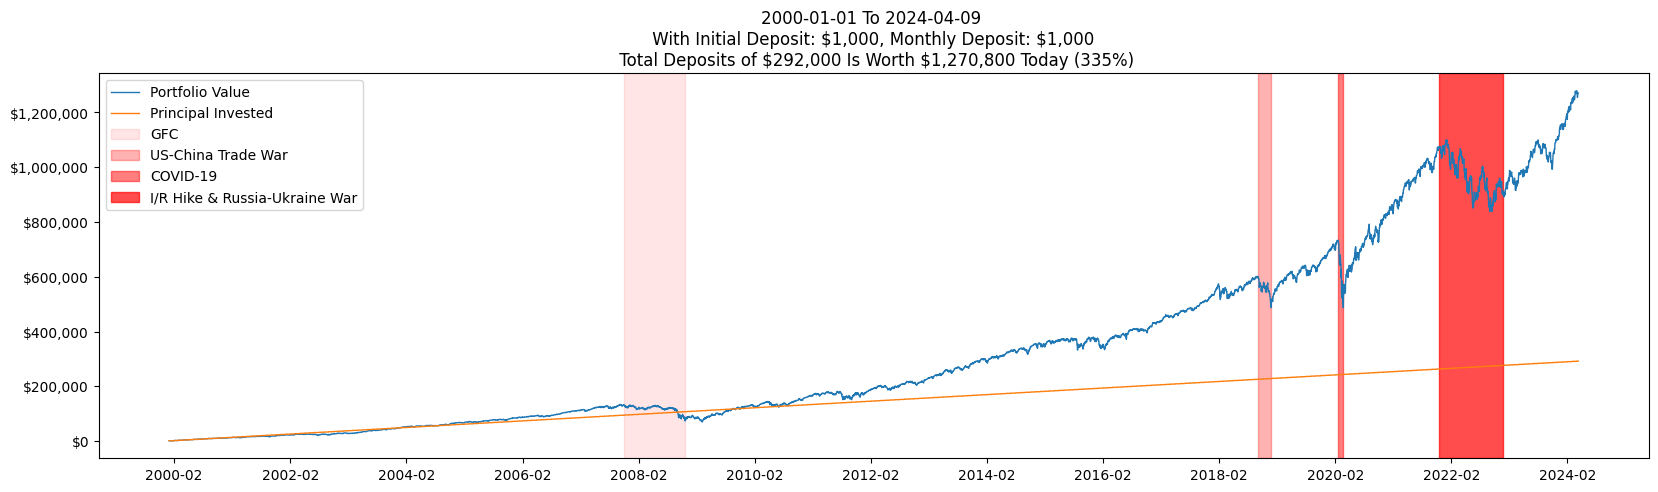

In [4]:
max_date = port['Date'].max()

invest_date = pd.date_range('2000-01-01', max_date, freq = 'MS').strftime('%Y-%m-%d').tolist()

first_invest_date = invest_date[0]
initial_sum = 1000
dca_amt = 1000

dcas = DCA(port, invest_date, initial_sum, dca_amt)
port_ret, port_principal = compute_investment(dcas, initial_sum, dca_amt)
plot_investment(port_ret, port_principal, first_invest_date, max_date, initial_sum, dca_amt)

## Lump Sum Investment

Investing an equivalent lump sum of $ 292,000 on 1st Jan 2000

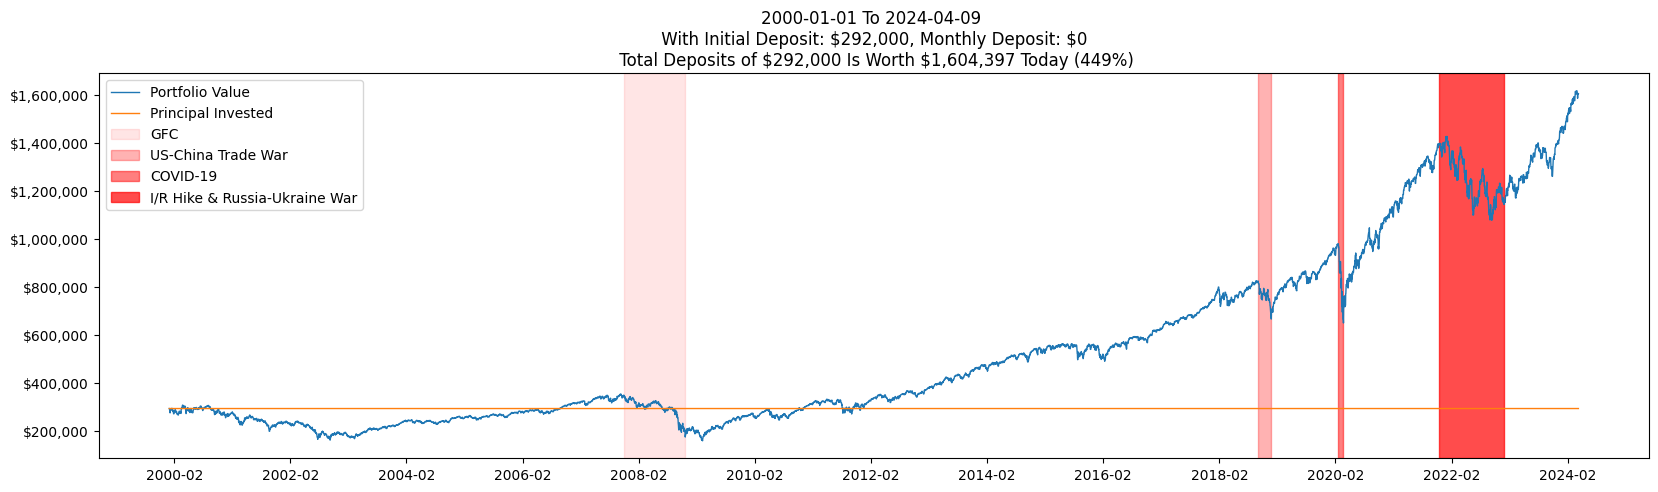

In [5]:
initial_sum = 292000
dca_amt = 0

dcas = DCA(port, invest_date, initial_sum, dca_amt)
port_ret, port_principal = compute_investment(dcas, initial_sum, dca_amt)
plot_investment(port_ret, port_principal, first_invest_date, max_date, initial_sum, dca_amt)